## Modeling

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.pipeline import make_pipeline as imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [2]:
data = pd.read_csv('../data/caffeine.csv')

### Baseline Model

In [3]:
data['type'].value_counts(normalize=True)

Energy Drinks    0.359016
Coffee           0.283607
Soft Drinks      0.147541
Tea              0.108197
Energy Shots     0.059016
Water            0.042623
Name: type, dtype: float64

> The majority class is 'Energy Drinks'. They have a frequency of 0.36, so that is the baseline model score and the one to improve upon.

#### Simple Logistic Regression with Caffeine Content Only

In [26]:
X = data[['Caffeine (mg)']]
y = data['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [27]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [28]:
lr = LogisticRegression(max_iter=10_000)
lr.fit(X_train_sc, y_train)
print(lr.score(X_train_sc, y_train), lr.score(X_test_sc, y_test))
print(balanced_accuracy_score(y_test, lr.predict(X_test_sc)))

0.45076586433260396 0.48366013071895425
0.31194656371602786


> As these scores are super low, Caffeine as a sole estimator of the type of drink is not great. Will try the other features.

#### Simple Logistic Regression with All Features Except Drink Name

In [14]:
data.head(2)

,drink,Volume (ml),Calories,Caffeine (mg),type
0,Costa Coffee,256.993715,0,277,Coffee
1,Coffee Friend Brewed Coffee,250.191810,0,145,Coffee


In [29]:
X = data.drop(columns=['drink', 'type'])
y = data['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [30]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [31]:
lr = LogisticRegression(max_iter=10_000)
lr.fit(X_train_sc, y_train)
print(lr.score(X_train_sc, y_train), lr.score(X_test_sc, y_test))
print(balanced_accuracy_score(y_test, lr.predict(X_test_sc)))

0.5864332603938731 0.6209150326797386
0.5491128197456634


> The scores here improve, but not by a large margin. Will add drink names in next.

#### Simple Logistic Regression with All Features

In [32]:
X = data.drop(columns='type')
y = data['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [36]:
ct = make_column_transformer(
    (CountVectorizer(), 'drink'), 
    (StandardScaler(), ['Volume (ml)', 'Calories', 'Caffeine (mg)']), 
    remainder='passthrough'
)

In [37]:
pipe1 = make_pipeline(ct, LogisticRegression(max_iter=10_000))
pipe1.fit(X_train, y_train)
print(pipe1.score(X_train, y_train), pipe1.score(X_test, y_test))
print(balanced_accuracy_score(y_test, pipe1.predict(X_test)))

0.9890590809628009 0.9084967320261438
0.9167440478657988


> This model is doing significantly better. My guess is because the common words in the drink name correspond to the type name. Will now try with adding those top words to stop words.

#### Logistic Regression with All Features, Adding Common Words to Stop Words

In [114]:
stop_words = ['coffee', 'energy', 'drink', 'cola', 'tea', 'shot', 'water', 'sparkling']
ct2 = make_column_transformer(
    (CountVectorizer(stop_words=stop_words), 'drink'), 
    (StandardScaler(), ['Volume (ml)', 'Calories', 'Caffeine (mg)']),
    remainder='passthrough'
)

In [115]:
pipe2 = make_pipeline(ct2, LogisticRegression(max_iter=10_000))
pipe2.fit(X_train, y_train)
print(pipe2.score(X_train, y_train), pipe2.score(X_test, y_test))
print(balanced_accuracy_score(y_test, pipe2.predict(X_test)))

0.9671772428884027 0.869281045751634
0.8042300420489917


> As expected, the scores went down, but not as low as I thought they might. The other words in the drink names seem to be having an influence over predicting the type of drink.

In [118]:
pipe2.named_steps['logisticregression'].classes_

array(['Coffee', 'Energy Drinks', 'Energy Shots', 'Soft Drinks', 'Tea',
       'Water'], dtype=object)

In [117]:
np.expm1(pd.DataFrame(pipe2.named_steps['logisticregression'].coef_[3],\
             index=pipe2.named_steps['columntransformer'].get_feature_names_out(),\
             columns=['coefs']).sort_values(by='coefs', ascending=False))

,coefs
countvectorizer__diet,4.275796
countvectorizer__pepsi,2.807569
countvectorizer__soda,2.799715
countvectorizer__mountain,1.659327
countvectorizer__coca,1.557014
...,...
countvectorizer__train,-0.329707
countvectorizer__black,-0.334916
countvectorizer__sobe,-0.368339
countvectorizer__iced,-0.615082


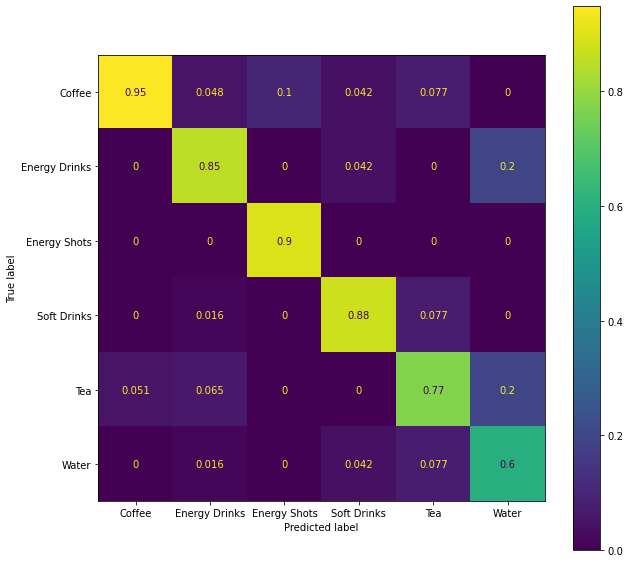

In [65]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test, ax=ax, normalize='pred');

> As water is our smallest class, this model is having the hardest time predicting that - it's only correct in the test set around 60% of the time. Will try to work with imblearn to improve that score.

### Working with imblearn for Unbalanced Data

#### RandomOverSampler

In [75]:
pipe3 = imb_pipeline(
    ct2, 
    RandomOverSampler(random_state=42), 
    LogisticRegression(max_iter=10_000)
)

In [91]:
gs1 = GridSearchCV(
    pipe3, 
    {'randomoversampler__sampling_strategy': ['minority', 'auto', 'all']}, 
    n_jobs=-1,
    scoring='balanced_accuracy'
)
gs1.fit(X_train, y_train)

print(gs1.score(X_train, y_train), gs1.score(X_test, y_test))
print(gs1.best_params_)

0.9842072470667301 0.8633962596283419
{'randomoversampler__sampling_strategy': 'auto'}


> The balanced accuracy here improved over the Logistic Regression model with pipe2.

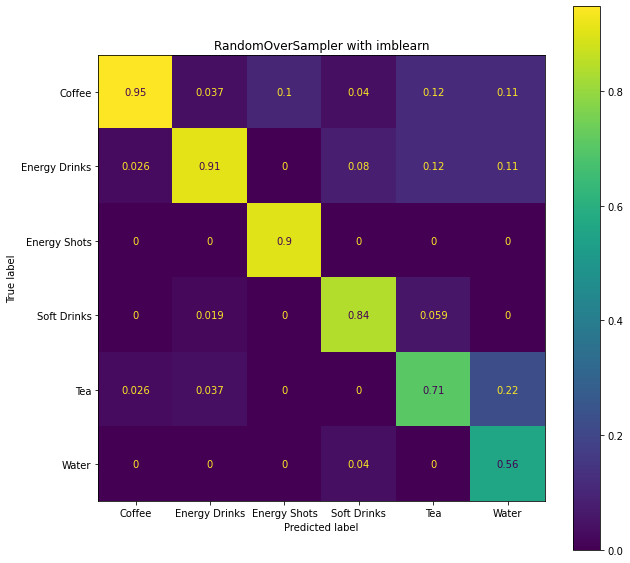

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(gs1, X_test, y_test, normalize='pred', ax=ax)
plt.title('RandomOverSampler with imblearn');

---

#### SMOTE

> This wound up being the best performing model

In [87]:
pipe4 = imb_pipeline(
    ct2,
    SMOTE(random_state=42),
    LogisticRegression(max_iter=10_000)
)

In [89]:
gs2 = GridSearchCV(
    pipe4, 
    {'logisticregression__C': [.1,1,10]}, 
    n_jobs=-1,
    scoring='balanced_accuracy'
)

In [92]:
gs2.fit(X_train, y_train)
print(gs2.score(X_train, y_train), gs2.score(X_test, y_test))
print(gs2.best_params_)

1.0 0.8604986100822655
{'logisticregression__C': 10}


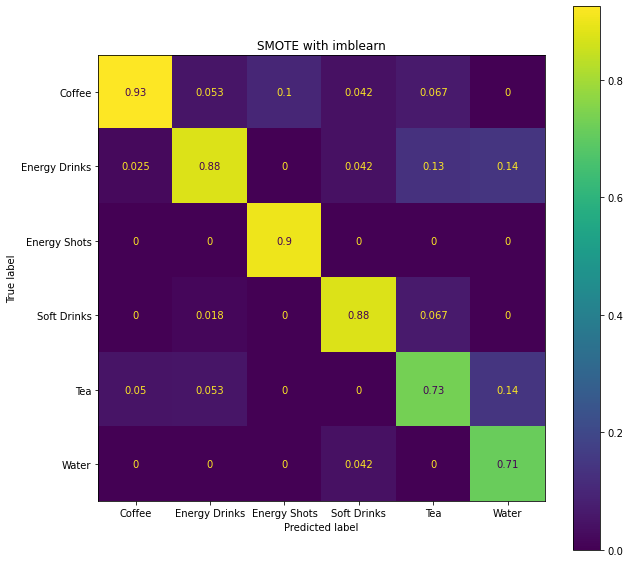

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test, normalize='pred', ax=ax)
plt.title('SMOTE with imblearn');

> This test score is just slightly lower than the RandomOverSampler, but it seems to be doing better at predicting the water class.

In [126]:
data['type'].value_counts()

Energy Drinks    219
Coffee           173
Soft Drinks       90
Tea               66
Energy Shots      36
Water             26
Name: type, dtype: int64

In [121]:
gs2.best_estimator_.named_steps['logisticregression'].classes_

array(['Coffee', 'Energy Drinks', 'Energy Shots', 'Soft Drinks', 'Tea',
       'Water'], dtype=object)

##### Coffee Coefs

In [130]:
np.expm1(pd.DataFrame(gs2.best_estimator_.named_steps['logisticregression'].coef_[0],\
            index=gs2.best_estimator_.named_steps['columntransformer'].get_feature_names_out(),
            columns=['coefs']).sort_values(by='coefs', ascending=False)).head()

,coefs
Caffeine (mg),65.456289
espresso,43.808971
decaf,28.488559
starbucks,21.305476
cappuccino,17.447013


> Caffeine content is the strongest predictor of this class.

##### Energy Drinks Coefs

In [131]:
np.expm1(pd.DataFrame(gs2.best_estimator_.named_steps['logisticregression'].coef_[1],\
            index=gs2.best_estimator_.named_steps['columntransformer'].get_feature_names_out(),
            columns=['coefs']).sort_values(by='coefs', ascending=False)).head()

,coefs
Caffeine (mg),25.811382
mix,20.117791
uk,7.588626
bruin,5.795741
tiger,4.937920


> Caffeine content is the strongest predictor in the Energy Drink class.

##### Energy Shots Coefs

In [132]:
np.expm1(pd.DataFrame(gs2.best_estimator_.named_steps['logisticregression'].coef_[2],\
            index=gs2.best_estimator_.named_steps['columntransformer'].get_feature_names_out(),
            columns=['coefs']).sort_values(by='coefs', ascending=False)).head()

,coefs
Caffeine (mg),114.268040
e6,2.812930
eternal,2.326281
eleven,2.046869
potion,1.872149


> Caffeine content was the strongest predictor of Energy Shots out of all the classes.

##### Soft Drinks Coefs

In [133]:
np.expm1(pd.DataFrame(gs2.best_estimator_.named_steps['logisticregression'].coef_[3],\
            index=gs2.best_estimator_.named_steps['columntransformer'].get_feature_names_out(),
            columns=['coefs']).sort_values(by='coefs', ascending=False)).head()

,coefs
zevia,43.254276
diet,30.242690
pepsi,18.785641
fresca,16.078169
soda,11.394640


> Fresca and Zevia weren't in top words. SMOTE changed their count, so if Zevia and Fresca were to show up more, they would carry more weight in predicting this class.

##### Tea Coefs

In [134]:
np.expm1(pd.DataFrame(gs2.best_estimator_.named_steps['logisticregression'].coef_[4],\
            index=gs2.best_estimator_.named_steps['columntransformer'].get_feature_names_out(),
            columns=['coefs']).sort_values(by='coefs', ascending=False)).head()

,coefs
iced,65.171581
green,16.593620
snapple,16.042533
hicaf,15.307544
guayusa,15.030532


> Hicaf, guayusa didn't show up during EDA very much. Since the counts were adjusted, they would carry more weight if they showed up in the test set more often.

##### Water Coefs

In [136]:
np.expm1(pd.DataFrame(gs2.best_estimator_.named_steps['logisticregression'].coef_[5],\
            index=gs2.best_estimator_.named_steps['columntransformer'].get_feature_names_out(),
            columns=['coefs']).sort_values(by='coefs', ascending=False)).head()

,coefs
guru,37.719097
yerbae,28.934627
arti,25.656447
Volume (ml),22.837656
phocus,22.651022


> Guru is a sparkling energy water, Arti is a brand of sparkling water. Volume (ml) is a distinct predictor of this class.

---

#### ADASYN

In [104]:
pipe5 = imb_pipeline(
    ct2,
    ADASYN(n_jobs=-1, random_state=42),
    LogisticRegression(max_iter=10_000)
)

In [105]:
gs3 = GridSearchCV(
    pipe5, 
    {'logisticregression__C': [.1,1,10]}, 
    n_jobs=-1,
    scoring='balanced_accuracy'
)

In [106]:
gs3.fit(X_train, y_train)
print(gs3.score(X_train, y_train), gs3.score(X_test, y_test))
print(gs3.best_params_)

1.0 0.8574683070519625
{'logisticregression__C': 10}


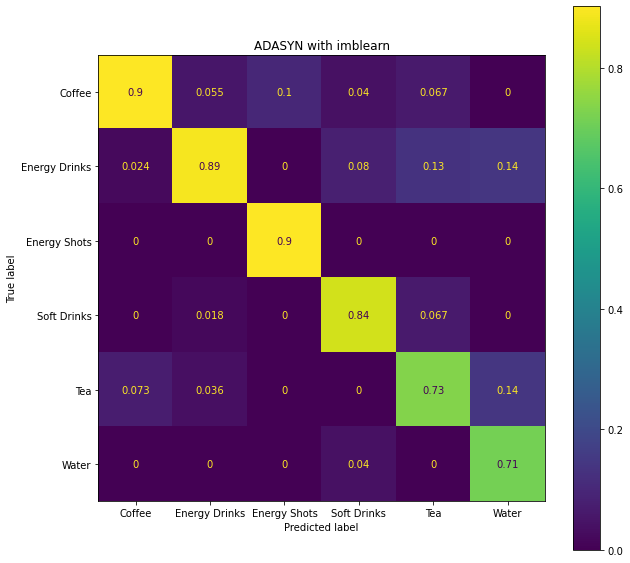

In [108]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(gs3, X_test, y_test, normalize='pred', ax=ax)
plt.title('ADASYN with imblearn');

> Not much of a difference.

#### Overweight Minority Class

In [109]:
pipe6 = make_pipeline(ct2, LogisticRegression(max_iter=10_000, class_weight='balanced'))

In [112]:
pipe6.fit(X_train, y_train)
balanced_accuracy_score(y_test, pipe6.predict(X_test))

0.8662939091744183

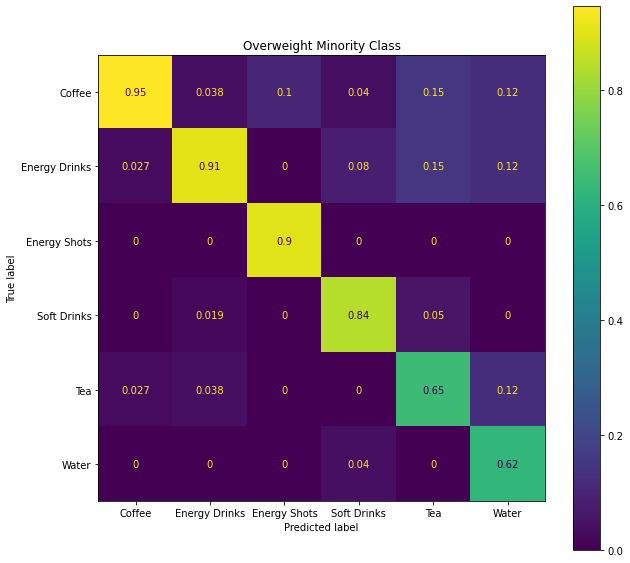

In [113]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(pipe6, X_test, y_test, normalize='pred', ax=ax)
plt.title('Overweight Minority Class');

> Not much of an improvement over the accuracy of the Logistic Regression model without using imblearn.

## Conclusion

The best predictive model that was achieved during this hackathon was an imlearn model with Logistic Regression and SMOTE, as this dataset was fairly imbalanced. It also used Count Vectorizer for the 'drink' column, with stop words including the most common words in each type class, and standard scaler on the numerical features. This model increased it's correct predictions on the minority class, Water. It wound up with a balanced accuracy score on the test set of 0.86. This is an improvement over the baseline accuracy of 0.36.

With this best model, it was really interesting to see the coefficients that came out of the model for each class and how they change from the EDA process. Some of the coefficient words that came up from the drink name were ones that weren't prevalent at all during EDA as they were so few, but working with SMOTE allowed them to be increased and thus properly scored alongside the other prevalent words. I also thought it was interesting how caffeine content was the strongest predictor of Energy Shots, and by a long shot too. It was 114 times more likely to predict Energy Shots, 25 times more likely to predict Energy Drinks, and 65 times more likely to predict Coffee. It wasn't in the top 5 for Soft Drinks, Tea, or Water.

For future steps, I'd like to explore other model types as well to see if that score can improve. For this hackathon I only focused on Logistic Regression with many different types of parameters and features. 